# 找到各個A圖到B圖，每點最像的前三個點。前置作業，讀檔、找特徵點。

In [13]:
# import 套件

import numpy as np
import cv2
import random
import heapq
import matplotlib.pyplot as plt
%matplotlib inline

### Translate轉換到大張圖上的function

In [14]:
""" 輸入xy，輸出能對到黑圖的xy """
def translateToBlackImg(x, y):
    # 位移量
    Tx = 250
    Ty = 250
    M_translation = np.array([
        (1,  0,  Tx),
        (0,  1,  Ty),
        (0,  0,  1),
    ])
    pair = np.dot(M_translation, np.array([x,y,1]))
    return pair

In [15]:
def SIFT(imgA, imgB):
    # 彩色轉灰階
    imgAgray = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
    imgBgray = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)

    # SIFT
    sift = cv2.xfeatures2d_SIFT().create()

    # find the keypoints and descriptors with SIFT
    # SIFT產生KeyPoint和其descriptor
    kp1, des1 = sift.detectAndCompute(imgAgray, None)
    kp2, des2 = sift.detectAndCompute(imgBgray, None)
    return kp1, des1, kp2, des2

# 開始計算。從A圖找最近的前三個點，並只採用與最近的點之距離在圖中所有點之10%(100內)

In [16]:
""" 輸入單一點特徵值和第二張圖的所有點特徵陣列，輸出最接近之(圖片index, 距離) """
def findNearest(target_des, second_des_arr):
    distance = []
    for i in second_des_arr:
        distance.append(np.linalg.norm(target_des - i))
    # 取前三接近 [(圖片1index, 距離),(圖片2index, 距離),(圖片3index, 距離)]
    Ksmallest = map(lambda n: (distance.index(n), n), heapq.nsmallest(3, distance))
    return list(Ksmallest)

In [17]:
def get_suitable_point(kp1, des1, kp2, des2):
    distance_list = []

    # 找出A圖點對B圖的所有點的距離
    for i in range(len(kp1)):
        distance = findNearest(des1[i], des2)
        distance_list.append(distance)
        
    # 找出可靠的幾個點
    reliable_points = []
    for i in range(len(distance_list)):
        """ content => [(29, 352.12073), (397, 396.2537), (233, 397.76376)] """
        content = distance_list[i]

        # i[0][1] 可以取到最近的點之距離(271.92096之類的)，小於100選用
        if content[0][1] < 80:
            reliable_points.append([i, content])
        # reliable_points => 多個 [199, [(32, 78.657486), (449, 203.3224), (547, 209.7856)]]
    return reliable_points

# 計算homography矩陣。隨機取四個出來，拿來算Affine Transformation。(Run cell below)

In [18]:
def get_random_points(reliable_points, kp1 ,kp2):
    # 亂數index產生
    rand_index_list = []
    for i in range(4):
        rand_index = int(random.random() * len(reliable_points))
        rand_index_list.append(rand_index)
        # rand_index_list => 多個 [71, 45, 64, 139]

    # 取得座標，對應的keypair
    source_point = []
    destination_point = []

    # A圖選任意4個點index
    for rand in rand_index_list:
        print("random number:", rand)
        indexA = reliable_points[rand][0]
        indexB = reliable_points[rand][1][0][0]
        print("index from A picture:", indexA)
        print("index from B picture:", indexB)

        # A圖 點座標
        pt_a = kp1[indexA].pt
        # B圖 點座標
        pt_b = kp2[indexB].pt

        print("point from A picture:", pt_a)
        print("point from B picture:", pt_b)

        source_point.append(pt_a)
        destination_point.append(pt_b)
    print()
    return source_point, destination_point

In [19]:
def calculate_affine_matrix(source_point, destination_point):
    # def calculate_affine(source_point, destination_point):
    source_point = np.array(source_point)
    destination_point = np.array(destination_point)

    source_point = source_point.reshape(8)
    destination_point = destination_point.reshape(8)

    # 8*6 大矩陣，已知
    matrix_A = np.zeros((8, 6))
    # 1*6 abcdef，轉過去用的矩陣，未知
    matrix_Affine = np.zeros((6))
    # 1*8 B圖的對應點組成的矩陣，已知
    matrix_B = np.array(destination_point)
    matrix_B = matrix_B.reshape((8, 1))

    x1 = source_point[0]
    y1 = source_point[1]
    x2 = source_point[2]
    y2 = source_point[3]
    x3 = source_point[4]
    y3 = source_point[5]
    x4 = source_point[6]
    y4 = source_point[7]

    matrix_A = np.array([
        (x1, y1, 1, 0, 0, 0),
        (0, 0, 0, x1, y1, 1),
        (x2, y2, 1, 0, 0, 0),
        (0, 0, 0, x2, y2, 1),
        (x3, y3, 1, 0, 0, 0),
        (0, 0, 0, x3, y3, 1),
        (x4, y4, 1, 0, 0, 0),
        (0, 0, 0, x4, y4, 1),
    ])

    # Affine轉換矩陣
    matrix_Affine = np.dot(np.linalg.pinv(matrix_A), matrix_B)
    matrix_Affine = matrix_Affine.reshape((2, 3))
    return matrix_Affine

### Controller

In [20]:
def stich_image(imgA, imgB):
    kp1, des1, kp2, des2 = SIFT(imgA, imgB)
    reliable_points = get_suitable_point(kp1, des1, kp2, des2)
    source_point, destination_point = get_random_points(reliable_points, kp1, kp2)
    matrix_Affine = calculate_affine_matrix(source_point, destination_point)
    
    # 把imgA顏色蓋到黑圖上
    # Using for loop to iterate every point -> find (Xa,Ya) -> (Xb,Yb)
    for y in range(imgA.shape[0]):
        for x in range(imgA.shape[1]):
            # get Affine Mappings location through matrix
            dot_prime = np.dot(matrix_Affine, np.array([x,y,1]))

            # 計算出來的A圖到B圖之坐標系
            x_loc = int(dot_prime[0])
            y_loc = int(dot_prime[1])

            pair = translateToBlackImg(x_loc, y_loc)
            blank_image[pair[1]][pair[0]] = imgA[y][x]

# Main

In [21]:
# 讀檔
img1 = cv2.imread("./picture_file/data6/pic1.jpg")
img2 = cv2.imread("./picture_file/data6/pic2.jpg")
img3 = cv2.imread("./picture_file/data6/pic3.jpg")
img4 = cv2.imread("./picture_file/data6/pic4.jpg")
img5 = cv2.imread("./picture_file/data6/pic5.jpg")

# 做很大張的黑底圖，蓋圖片用的
blank_image = np.zeros((1000,1000,3), np.uint8)

# 圖一先上 
for y in range(img1.shape[0]):
    for x in range(img1.shape[1]):
        pair = translateToBlackImg(x,y)
        blank_image[pair[1]][pair[0]] = img1[y][x]

stich_image(img2, img1)
stich_image(img3, img1)
stich_image(img4, img1)
stich_image(img5, img1)

random number: 121
index from A picture: 792
index from B picture: 1154
point from A picture: (404.9104919433594, 428.3486328125)
point from B picture: (400.7877502441406, 320.90216064453125)
random number: 127
index from A picture: 823
index from B picture: 1244
point from A picture: (422.77838134765625, 312.243896484375)
point from B picture: (423.54693603515625, 209.63217163085938)
random number: 158
index from A picture: 956
index from B picture: 1412
point from A picture: (456.74847412109375, 322.97552490234375)
point from B picture: (456.98321533203125, 219.93373107910156)
random number: 89
index from A picture: 562
index from B picture: 843
point from A picture: (298.50567626953125, 313.93145751953125)
point from B picture: (298.9090576171875, 213.67735290527344)

random number: 202
index from A picture: 1142
index from B picture: 1055
point from A picture: (366.8664855957031, 287.7658996582031)
point from B picture: (365.08636474609375, 356.033203125)
random number: 275
index f

### Show 圖片

In [22]:
cv2.imshow('Result', blank_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### JupyterNotebook看圖

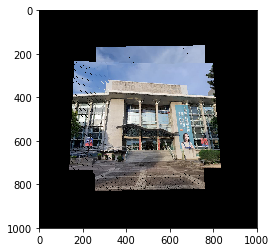

In [23]:
plt.imshow(cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB))
plt.show()

### 存檔

In [24]:
cv2.imwrite('./output_file/panorama5Imgs.jpg', blank_image)

True